[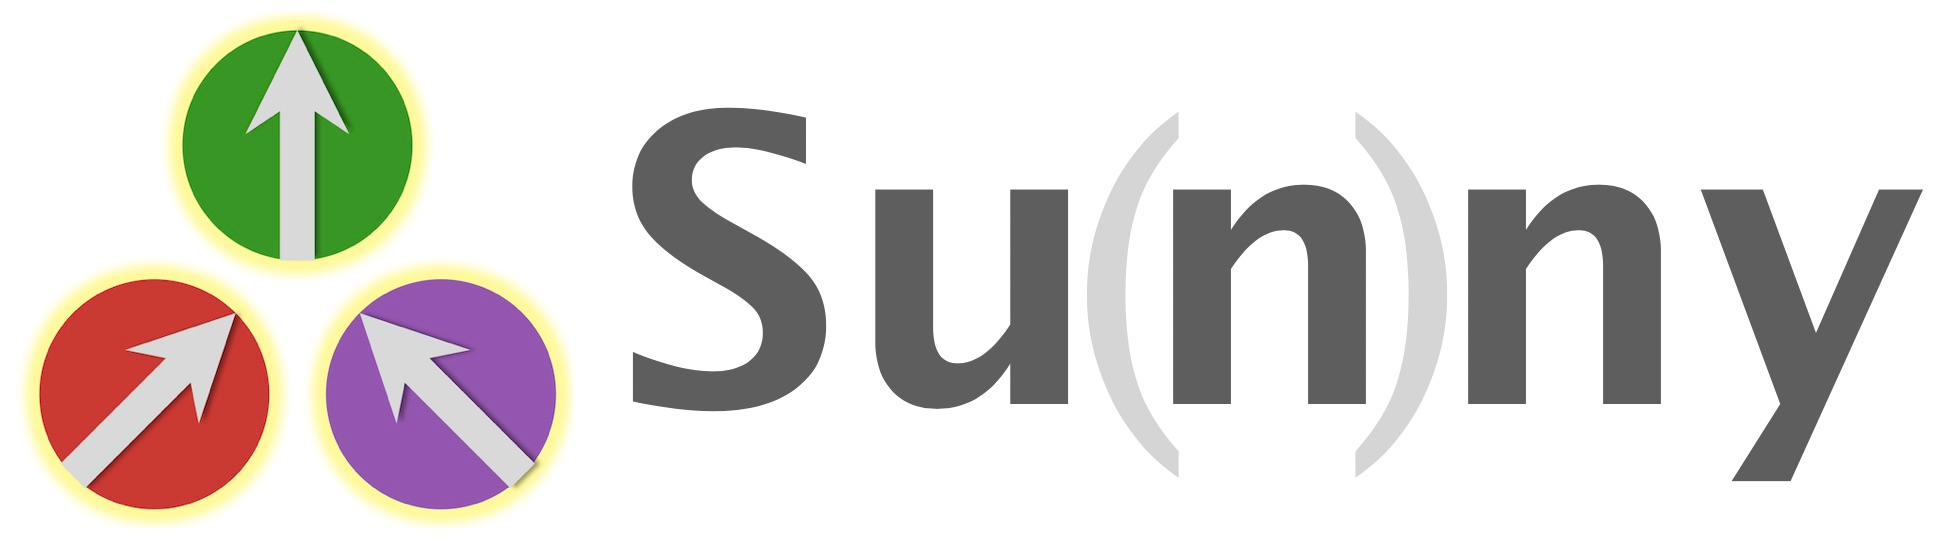](https://github.com/SunnySuite/Sunny.jl)

# SU(3) Case Study: FeI$_{2}$

**VERSION REQUIREMENTS** Requires Sunny#main as of 2023-01-20. \[Soon to be v0.4.0\.]

In this tutorial, we will walk through the process of calculating the dynamical properties of the compound FeI$_2$. This is an effective spin 1 material with strong single-ion anisotropy, making it an excellent candidate for treatment with generalized SU(3) spin dynamics.  In particular, the excitations of the system can only be captured classically with an SU(3) treatment. One magnon, clearly visible in the experimental data, would simply be absent if we were to employ traditional Landau-Lifshitz dynamics or SU(2) spin wave theory. Full details about the model can be found in reference [\[1\]](https://doi.org/10.1038/s41567-020-01110-1).

The model that we will be studying consists of a number of competing, anisotropic exchange interactions and a strong single-ion anisotropy term. Writing the exchange interactions in the most general way, the Hamiltonian simply has the form:

$\mathcal{H} = \sum_{\left(i,j\right)}J_{ij}\mathbf{S}_i\cdot\mathbf{S}_j - D\sum_i \left(S_i^z\right)^2$

We will begin by implementing this Hamiltonian in Sunny. To get started, we will import all the necessary Julia packages. The plotting packages may take a minute to load. Once imported, things will go more quickly. If you see an error "Package X not found in current path", you can install the package X by entering `using Pkg; pkg"add X"`.

In [1]:
using Sunny, Formatting, GLMakie, Random, JLD2
import Plots

This command will inject Javscript code into the Jupyter notebook to allow the crystal viewer to work without an internet connection.

In [2]:
Sunny.offline_viewers()

SunnyViewer(...)

## Setting up the Crystal

Sunny has a number of facilities for specifying a crystal. If a CIF file is available, it can be loaded using `Crystal("file.cif")`. Here, instead, we will directly specify the lattice vectors and atom positions for a unit cell.

In [3]:
a = b = 4.05012  # angstroms
c = 6.75214
lat_vecs = lattice_vectors(a, b, c, 90, 90, 120) # This a convenience method. Alternatively,
                                                 # lattice vectors could be specified as
                                                 # columns of a 3x3 matrix.
types = ["Fe", "I", "I"]
basis_vecs = [[0,0,0], [1/3, 2/3, 1/4], [2/3, 1/3, 3/4]] # Locations of atoms as multiples of lattice vectors

cryst = Crystal(lat_vecs, basis_vecs; types)

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]
Type 'I', Wyckoff 2d (point group '3m.'):
   2. [0.3333, 0.6667, 0.25]
   3. [0.6667, 0.3333, 0.75]


Observe that Sunny inferred the space group `'P -3 m 1'`, corresponding to the international number 164. This is consistent with the table below, taken from reference [1]. Specifying the atom types can sometimes be necessary for Sunny to correctly infer the spacegroup symmetry.

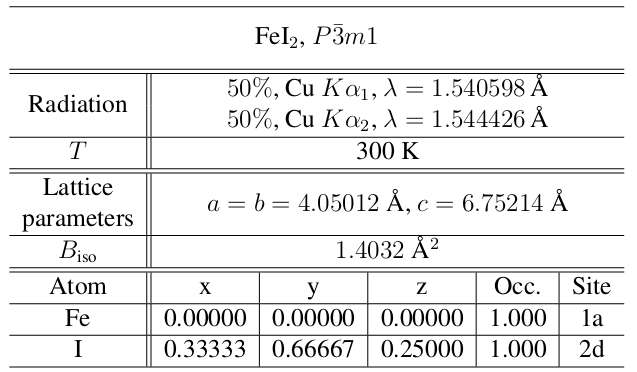

Alternatively, a `Crystal` can be constructed from a given spacegroup, here 164. The second I position will be inferred from the first one by symmetry.

In [4]:
types = ["Fe", "I"]
basis_vecs = [[0,0,0], [1/3, 2/3, 1/4]] # Locations of atoms as multiples of lattice vectors

cryst = Crystal(lat_vecs, basis_vecs, 164; types)

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]
Type 'I', Wyckoff 2d (point group '3m.'):
   2. [0.3333, 0.6667, 0.25]
   3. [0.6667, 0.3333, 0.75]


## 3D Visualization 

Sunny provides an interactive tool to visualize the 3D crystal structure, as well as the equivalence classes of "bonds."

In [5]:
view_crystal(cryst, 8.0)  # Second argument is maximum distance

SunnyViewer(...)

Dragging the mouse will rotate the crystal. Shift-dragging will translate. Spinning the mouse wheel (i.e., the window scroll action) will zoom.

Unselect the I checkbox to focus only on the Fe ions. We see that there are four equivalence classes of bonds between Fe ions within the specified radius of 8 Å.

The crystal viewer will be useful in conjunction with specifying interactions between bonds, as described below.

## Creating a `System` and Specifying Interactions

We now wish to instantiate our model in Sunny so that can we perform simulations. This is a two step process: first we will create a `System` and then we will add interactions to the `System`.


### Creating the `System`

A `System` is created by providing information about the crystal, finite lattice dimensions, local information about each spin of the unit cell of the lattice, and a simulation mode: `System(crystal::Crystal, latsize, spininfos, mode)`. 

Local site information is provided with a list of `SpinInfo`s. A `SpinInfo` is created by calling `SpinInfo(i, S; g=2)`. `i` refers to the atom within a unit cell, where the order corresponds to what was reported when instantiating the `Crystal`. `S` determines the total angular moment of the spin on site `i`. In dipole mode, the magnitude of a local dipole moment will be scaled to `S`. In SU(_N_) mode, `S` will be the magnitude of the generalized spin. (More precisely, simulations in SU(_N_) mode will use the $S$ irrep of SU(2) for the dipole operators, and the local Hilbert space will have complex dimension $N=2S+1$.) The optional keyword `g` is the local g-tensor, which, by default, is isotropic and has a magnitude of 2.

Sunny provides a number of different modes, set with the keyword argument `mode`. The two most important modes are `:SUN`, which is implements generalized SU(_N_) dynamics, and `:dipole` mode, which implements traditional Landua-Lifshitz dynamics.

We will now go ahead and start the process of building our `System`. We note that we are only interested in the magnetic behavior of the Fe ions, so we will begin by restricting our cyrstal to the Fe sublattice while preserving the symmetry properties of the original crystal using the `sublattice` function.

As we have only one atom per lattice cell in this case, we only need to specify a single `SpinInfo`. (Note that if we had multiple, symmetry-equivalent sites within the unit cell, Sunny would symmetry propagate the `SpinInfo` to all equivalent sites.) As we are simulating a spin-1 system, we will set `S=1`, and we will accept the default g-tensor.

Finally, note that we will be using SU(_N_) mode, so we will set the `mode` keyword to `:SUN`. 

In [6]:
Fe_cryst = subcrystal(cryst, "Fe")  # Restrict to sublattice defined by Fe while retaining symmetry properties of full crystal
latsize = (4,4,4)
S = 1
spininfos = [SpinInfo(1, S)]
mode = :SUN;

We can now create our `System`.

In [7]:
sys = System(Fe_cryst, latsize, spininfos, mode; seed=0) # Add an option RNG seed for consistent behavior

System [SU(3)]
Cell size 1, Lattice size (4, 4, 4)


Note that Sunny has made an `SU(3)` spin system. It has correctly inferred that, in SU(_N_) mode, the dimension of each local Hilbert space will be $N=2S+1=3$ for a $S=1$ system.


### Symmetry analysis of exchange interactions

At this point, our `System` is a sort of skeleton model as we have not yet added any interactions. We must assign the various interactions of the Hamiltonian given in reference [1] to the system.  Specifically, we have 6 different anisotropic exchange interactions as well as a single-ion anisotropy. We begin with the exchange terms.

The different bonds on which we wish to specify exchange interactions are illustrated with yellow arrows in the the following illustration \[1\]:

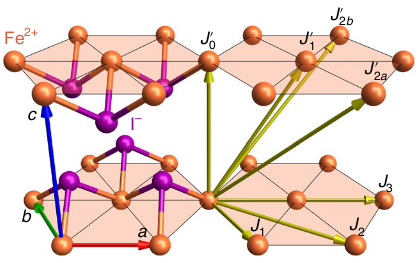

Correctly specifying these six interactions requires some care. Fortunately, Sunny provides tools to help. Like SpinW, Sunny can perform a symmetry analysis, listing both the symmetry-allowed interactions for a representative set of bonds up to some maximum cutoff distance as well as symmetry allowed g-factors and anisotropies for each unique site.

In [8]:
print_symmetry_table(Fe_cryst, 10.0)

Site 1
Type 'Fe', position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,-3] + c₃*𝒪[4,0] +
    c₄*𝒪[6,-3] + c₅*𝒪[6,0] + c₆*𝒪[6,6]

Bond(1, 1, [1, 0, 0])
Distance 4.05012, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [0, 0, 1])
Distance 6.75214, coordination 2
Connects 'Fe' at [0, 0, 0] to 'Fe' at [0, 0, 1]
Allowed exchange matrix: | A  0  0 |
                         | 0  A  0 |
                         | 0  0  B |

Bond(1, 1, [1, 2, 0])
Distance 7.01501361675086, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 2, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [1, 0, 1])
Distance 7.8736818956572, coordination 12
Connec

Sunny has provided us with a great deal of useful information here, and it is worth dissecting the results.

At the very top of the list, Sunny provides the allowed form of a g-tensor for each site as well as the general form of any permissible single site anisotropy. The latter is given in terms of a linear combination of Stevens operators. We will return to this information later. Let's move on to the exchange interactions.

The precise syntax for specifying a bond is given in bold at the top of each entry, e.g., `Bond(1, 1, [1, 0, 0])`. The first two arguments specify a pair of sites with an implied orientation (_from_ the first ion _to_ the second). The sites are numbered according to the list provide when making the `Crystal`. Since our cyrstal only contains a single site per unit cell -- the Fe ion -- the first two arguments to `Bond` will always be 1. The list provided as the final argument to `Bond` specifies an offset in terms of lattice vectors. So `Bond(1, 1, [1, 0, 0])` refers to the bond between the same ion in two different unit cells, specifically the unit cell that is offset one $a$ lattice vector from the origin.

The length of the bond is given by `Distance`, which is useful for determining different orders of nearest neighbor. The coordinates of both the origin and destination of the bond are given in fractional coordinates. Finally, we should note that Sunny provides the allowed form of any exchange matrix that is assigned to the bond. If you try to give Sunny an exchange matrix that does not match this form, it will not allow you to build your model.

It is of course possible to work through the bond table and establish a correspondence between different bonds and the figure provided in the paper. For example, we can see that `Bond(1, 1, [1, 0, 0])` refers to $J_1$ in the illustration, since it is the shortest in-plane bond in the table. However, the crystal viewer introduced above can be a great aid in this process, and we encourage the reader to experiment with the viewer to establish correspondences with the information in the bond table. For example, selecting all the `J1` bonds in the crystal viewer will make the hexagonal unit from illustration \[1\] clearly visible.

### Assigning exchange interactions to the `System`

An exchange interaction is assigned to a particular bond with the `set_exchange!(sys, J, bond)`, where `J` is a 3x3 exchange matrix and `bond` follows the format of `print_symmetry_table()`. For example, nearest neighbor interactions can be specified using `set_exchange!(sys, J, Bond(1, 1, [1, 0, 0]))`. 

We follow this procedure below, assigning the exchange matrices provided in reference [1] to their corresponding bonds in our crystal. We encourage the reader to go through this exercise independently, but the final result is below.

In [9]:
# ---------- Parameters as given in supplementary information ---------- #
J1pm   = -0.236
J1pmpm = -0.161
J1zpm  = -0.261

J2pm   = 0.026

J3pm   = 0.166

J′0pm  = 0.037

J′1pm  = 0.013

J′2apm = 0.068
D      = 2.165

J1zz   = -0.236
J2zz   = 0.113
J3zz   = 0.211
J′0zz  = -0.036
J′1zz  = 0.051
J′2azz = 0.073
J′2bzz = 0.0

# ---------- Parameters transformed into exchange matrices ---------- #
J1xx = J1pm + J1pmpm 
J1yy = J1pm - J1pmpm
J1yz = J1zpm

J₁ = [J1xx  0.0   0.0;
      0.0   J1yy  J1yz;
      0.0   J1yz  J1zz]

J₂ = [J2pm  0.0  0.0;
      0.0   J2pm 0.0;
      0.0   0.0  J2zz]

J₃ = [J3pm   0.0   0.0;
      0.0    J3pm  0.0;
      0.0    0.0   J3zz]

J′₀ = [J′0pm  0.0   0.0;
       0.0    J′0pm 0.0;
       0.0    0.0   J′0zz]

J′₁ = [J′1pm  0.0   0.0;
       0.0    J′1pm 0.0;
       0.0    0.0   J′1zz]

J′₂ = [J′2apm  0.0   0.0;
       0.0    J′2apm 0.0;
       0.0    0.0   J′2azz]

# ---------- Assign the exchange matrices to bonds ---------- #
set_exchange!(sys, J₁, Bond(1,1,[1,0,0]))
set_exchange!(sys, J₂, Bond(1,1,[1,2,0]))
set_exchange!(sys, J₃, Bond(1,1,[2,0,0]))
set_exchange!(sys, J′₀, Bond(1,1,[0,0,1]))
set_exchange!(sys, J′₁, Bond(1,1,[1,0,1]))
set_exchange!(sys, J′₂, Bond(1,1,[1,2,1]))

If any of the exchange matrices had violated the symmetry properties of the crystal, Sunny would have thrown an error. Sunny will also automatically propagate each exchange matrix to all symmetry equivalent bonds in the `System`, applying all necessary transformations.

### Onsite Anistropy


In addition to the exchange interactions specified above, the model includes a strong single-ion anisotropy term: $D\left(\hat{S}^z\right)^2$. Sunny allows the user to specify the anisotropy directly in this form, as it would appear in the quantum Hamiltonian. For this purpose Sunny provides the symbols 𝒮[1], 𝒮[2], 𝒮[3], corresponding to the x, y, and z spin operators. For example, we can create a variable representing our anisotropy as follows:

In [10]:
D = -2.165
aniso = D*𝒮[3]^2

-2.165𝒮₃²

The method for assigning an anisotropy to the `System` is very similar to the approach used for assigning exchange interactions. Here we use `set_anisotropy!(sys, op, i)`, where `i` is a site (rather than a bond). As with the exchange interactions, Sunny will perform symmetry analysis and will propagate the anisotropy to all equivalent sites.

In [11]:
set_anisotropy!(sys, aniso, 1)

In this case, we knew in advance that the symmetry would be allowed. Suppose that had not known this. Recall that when we called `print_symmery_table`, at the top of the report we found anisotropy information. Let's do so again, this time setting the radius of interest to 0 (since we're only concerned with one site).

In [12]:
print_symmetry_table(Fe_cryst, 0)

Site 1
Type 'Fe', position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,-3] + c₃*𝒪[4,0] +
    c₄*𝒪[6,-3] + c₅*𝒪[6,0] + c₆*𝒪[6,6]



Sunny here shows us the valid anisotropies expressed in terms of Stevens operators. Stevens operators are a set of basis functions with transformation properties similar to spherical harmonics. (Specifically, they are symmetrized spherical tensor operators). Like spherical harmonics, they are specified with two numbers, which we will call $k$ and $q$: $\mathcal{O}_{k,q}$. For any $k$, $q$ takes values in the range $-k \leq q \leq k$. As with the spin operators, Sunny provides symbols for the Stevens operators. For example, to specify the k=2, q=0 operator, simply write:

In [13]:
𝒪[2,0]

𝒪₂₀

We specified an anisotropy proportional to 𝒮₃². To find an equivalent expression in terms of Stevens operators, we can use `print_anisotropy_as_stevens`:

In [14]:
print_anisotropy_as_stevens(𝒮[3]^2; N=3)

(1/3)𝒪₂₀ + 2/3


This is in the form $c*𝒪[2,0]$, which is explicitly allowed by the symmetry analysis. Up to an irrelevant constant shift, our anisotropy could have equivalently been specified as `(D/3)*𝒪[2,0]`.

## Structure Factor Calculations
### Finding a Ground State

We now have a complete `System` with all our interactions specified. In the remainder of this tutorial, we will go through the basic steps necessary to calculate a dynamical spin structure factor (DSSF) for FeI$_2$. Sunny provides automated functionality for performing such calculations, but to use these tools it will be helpful to first find the system's ground state. In this section we will present one approach to achieving this.

It is possible to formulate an Langevin equation for the classical SU(N) dynamics supported by Sunny, i.e., to perform dynamical simulations in the presence of a thermal bath \[3\]. This is a very efficient approach to sampling states at finite temperatures and is one of Sunny's most powerful features. We can also use this feature to set up an annealing procedure and use the integretor to solve our optimization problem.

Since Langevin sampling involves the simulation of dynamics, it is first necessary to specify an Langevin integrator and its parameters. Sunny's Langevin integrator is called `LangevinHeunP`, and it takes a temperature, a damping coefficient (which determines the strength of the coupling to the thermal bath), and a simulation step size.

In [15]:
kT = 10.0  # meV
Δt  = abs(0.05 / D)  # Safe choice for integration step size, where the divisor is the largest coefficient in the Hamiltonian
λ = 0.1  # Damping coefficient, empirical value that determines decorrelation time

integrator = LangevinHeunP(kT, λ, Δt);

A `LangevinSampler` simply wraps the integrator together with information about how long to run the simulation between taking samples. Based on past experience, we will choose a duration of 30 meV$^{-1}$. We will calculate how many discrete steps this corresponds to and construct our sampler.

In [16]:
sample_dur = 30.0
num_steps = round(Int, sample_dur/Δt)

langevin_sampler = LangevinSampler(integrator, num_steps);

Now, every time we call `sample!(sys, langevin_sampler)`, Sunny will simulate the dynamics of our model for `num_steps` time steps. 

With our sampler in hand, we will establish a very basic annealing protocol: sampling once at each temperature in a sequence of temperatures that descend geometrically from some high value. A simple function will help facilitate this calculation.

In [17]:
function anneal!(sys, sampler, kTs)
      Es = zeros(length(kTs))        # Buffer for saving energy as we proceed

      for (i, kT) in enumerate(kTs)
            set_temp!(sampler, kT)
            sample!(sys, sampler)                    # Sample from the system
            Es[i] = energy(sys)   # Query the energy
      end
    
      return Es    # Return the energy values collected during annealing
end;

We can now perform the annealing procedure. 

In [18]:
kTs = [kT * 0.9^k for k in 0:100]
randomize_spins!(sys)   # Random initial conditions in the spin system (infinite temperature)
Es = anneal!(sys, langevin_sampler, kTs; )

# Run for a final stretch at 0 temperature
set_temp!(langevin_sampler, 0.0)
for _ in 1:5
    sample!(sys, langevin_sampler)
end

Let's examine the energies we calculated during the annealing process.

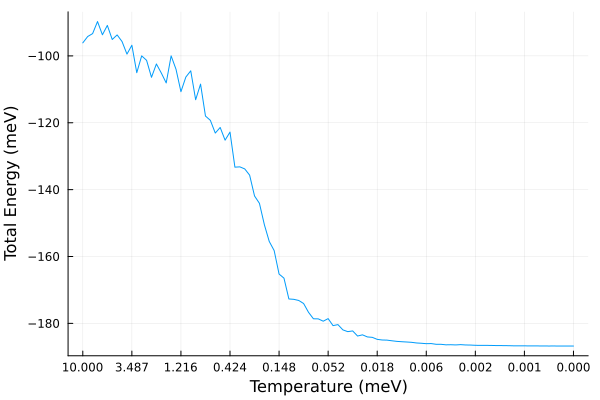

In [19]:
xtickvals = kTs[1:10:end]

Plots.plot(kTs, Es[end:-1:1];  xlabel="Temperature (meV)",
    ylabel="Total Energy (meV)", label=false, xscale=:log10, fmt=:png,
    xticks=(xtickvals, [format("{:.3f}", x) for x in xtickvals][end:-1:1])
                
)

We seem to have reached at least a local mininimum.  The actual ground state for this material is known for this model. It is a striped configurations. Each stripe is two spins wide, and the polarization of the stripes alternates. The axis of polarization is nearly the z-axis, but the spins are canted away from this axis slightly.

Let us take a look at the spin configuration that we have found to see if it matches this description. Sunny provides a function, `plot_spins`, for inspecting spin configurations. Note that it requires the `GLMakie` package. `plot_spins` will open a new window which will allow you to zoom and pan interactively. Note that it may take a little time for the first plot to appear.

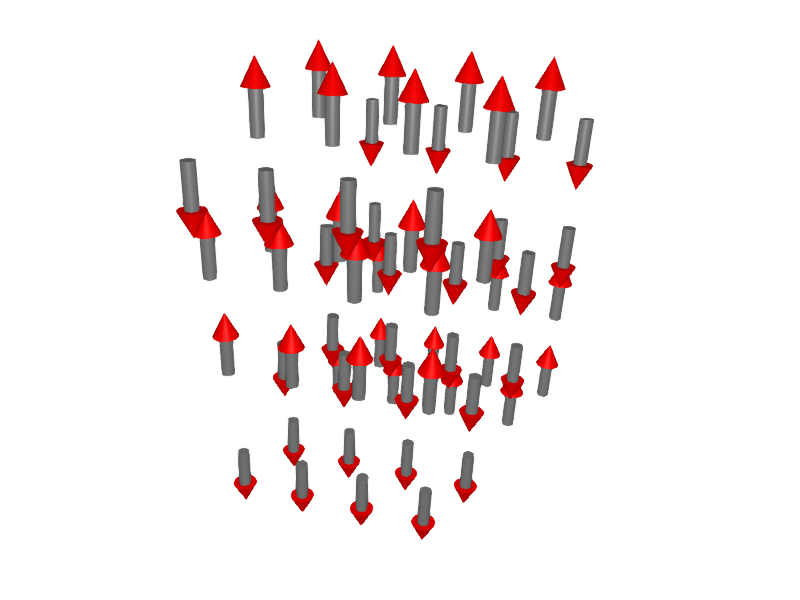

In [20]:
plot_spins(sys; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

Hopefully you see a result that matches the description given above. If not, try running the annealing process few times until you do. It's not uncommon to encounter domain formation. Sunny has a number of powerful tools for dealing with these situations, which you can learn about in forthcoming tutorials.

### Calculating a Dynamical Structure Factor

With our ground state in hand, we can begin performing the calculations to create a dynamical spin structure factor (DSSF).  This is useful for direct comparison with neutron scattering data.

Because Sunny performs calculations on a finite lattice, the resolution in momentum space will be limited by the size of the lattice. Specifically, along each axis $i$, we will get information at $q_i = \frac{2\pi n}{L_i}$, where $n$ runs from $(\frac{-L_i}{2}+1)$ to $\frac{L_i}{2}$ and $L_i$ is the linear dimension of the lattice. We therefore would like to work with as large a system as possible in order to maximize our momentum space resolution.

The spin system we used above is quite small. This choice was made to accelerate the process of finding a ground state and to avoid domain formation. The dimensions of the system were also selected so that they would be comensurate with the size of the magnetic unit cell, a choice that will allow us to simply be extend the system periodically to find a ground state of a larger system. The periodic extension can be accomplished with `extend_periodically(sys, mults)`. This function takes two arguments: your original spin system, and a tuple of integer multipliers to be applied to the size of the lattice along each axis. Because we are mostly interested in taking slices from the resulting structure factor along the $a^*$ and $b^*$ axis, we will only expand the size of our system along these two dimensions, in this case by a factor of 3.

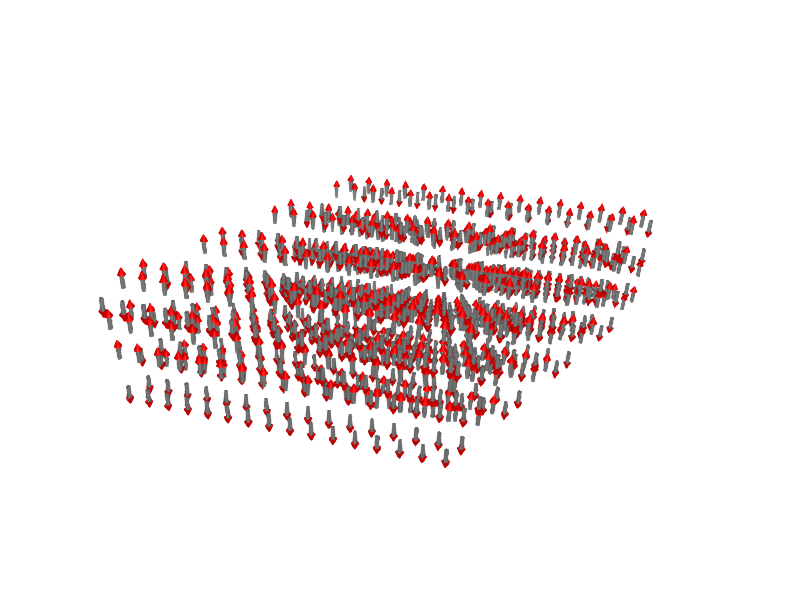

In [21]:
sys_big = extend_periodically(sys, (4, 4, 1)) 

plot_spins(sys_big; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

You should see a $16 \times 16 \times 4$ spin system in our striped ground state.

We are now in a position to start the calculation. The basic procedure consists of the following steps: (1) thermalizing the system; (2) taking sample spin configurations at equilibrium; (3) using these samples as initial conditions for the calculation of dynamical trajectories; and (4) calculating the correlation functions using a Fourier transform of the trajectories. While Sunny will allow you to customize each of these steps, in this tutorial we will instead demonstrate how to have Sunny automatically take care of the calculation using the `calculate_structure_factor` function: 

```
function calculate_structure_factor(sys, sampler;
    nω=1, ωmax=10.0, nsamples=10,
    apply_g=true, Δt = nothing, ops = nothing, matrix_elems = nothing
)
```

You have already seen how to create a `System` and a `LangevinSampler`, the first two arguments, so we focus on the optional keywords. We first consider those keywords that will be of general interest

- `ωmax`: This determines the maximum energy that will be resolved by the calculation. For example, if your model is specified in terms of meV and you are interested in resolving energies up to 10 meV, you would set this keyword to `10`. Note that the precise value is constrained by the simulation step size, so Sunny will pick the smallest possible value larger than the given value.
- `nω`: As Sunny performs a discrete time simulation, the resulting energy (frequency) information will be reported in discrete bins. `nω` determines how many bins there will be between 0 and `ωmax`. By default, `nω=1` and Sunny will calculate a static structure factor.
- `nsamples`: This simply determines how many samples to average over when calculating the structure factor. For temperatures close to 0, 1 sample is often enough to get a good impression. For higher temperatures and publication-quality figures, many more samples may be required.

The remaining keywords are primarily of interest to advanced users. We briefly summarize them here.

- `apply_g`: This tells Sunny whether or not to apply the local g-tensors to each spin when calculating trajectories. Most users will want to accept the default value of `true`.
- `Δt`: Sunny uses an energy-conserving implicit integration scheme "behind the scenes" to calculate the dynamics. `Δt` sets the step size of this integrator. If no value is provided, Sunny will determine the step size based on the step size used in the `LangevinSampler` that you provide. If you are using another type of sampler, you should set this keyword explicitly.
- `ops`: If you are in SU(_N_) and wish to track observables other than the dipoles, you can specify these operators setting `ops` an `N x N x numops` complex array, where `N` is the dimension of your local Hilbert space ($2S+1$), and `numops` is the number of operators.
- `matrix_elems`: This is primarily of interest to users who are tracking custom observables. In this case, you may wish to record only a subset of the set of all possible correlations. For example, if you provide two custom operators and only wish to calculate the autocorrelation of the first operator and the cross-correlation of the first and second operators, you would set `matrix_elems = [(1,1), (1,2)]`. By default, Sunny saves all the correlation functions of the the dipole, i.e. it will produce $\mathscr{S}^{\alpha\beta}(q,\omega)$ where $\alpha$ and $\beta$ range from 1 to 3, corresponding to the $x$, $y$ and $z$ components of the dipole.


We have already created our `System`, so we will begin by creating a sampler specifically for this calculation. As before, we'll first make a `LangevinIntegrator` and then use this to create a `LangevinSampler`. The number of time steps that the `LangevinSampler` will run before generating samples should be large enough that successive samples are decorrelated. Here we choose a duration we know to be sufficient. In your own studies, you can estimate the decorrelation time by running the dynamics using the `LangevinIntegrator` while tracking the energy or a relevant order parameter.

In [22]:
decorr_time = 2.0 # Time in meV^-1 required to get an uncorrelated sample
nsteps = round(Int, decorr_time/Δt) # Number of time steps corresponding to this duration
kT = 0.5 * Sunny.meV_per_K # Temperature in meV

integrator = LangevinHeunP(kT, λ, Δt);
langevin_sampler = LangevinSampler(integrator, nsteps);

Before initiating the calculation, it is essential to make sure that your `System` is in equilibrium. Currently our `System` is somewhere close to the ground state and needs to be thermalized. We achieve this simply by running the `LangevinSampler` a several times. (Again, we pick values here that we know to be effective. Your own model may require a different treatment.)

In [23]:
for _ in 1:6
    sample!(sys_big, langevin_sampler)
end

We are now ready to ask Sunny to calculate our dynamical structure factor. We simply set a few keyword parameters (described above) and call `calculate_structure_factor`. This may take up to a minute on a typical laptop.

In [24]:
ωmax=7.5    # Maximum energy to resolve
nω=120      # Number of energies to resolve
nsamples=3  # Number of samples to take

sf = calculate_structure_factor(sys_big, langevin_sampler; ωmax, nω, nsamples);

## Accessing Structure Factor Data

### Querying intensities at an arbitrary wave vector

The results of our calculation are returned as a `StructureFactor`, which we have called  `sf`. The simplest way of accessing the data contained in `sf` is with the function `get_intensites`. Here is a partial specification: 

```
function get_intensities(sf, qs, mode;
    interpolation = nothing,
    kT = nothing,
    formfactors = nothing,
)
```

If we accept all the default behaviors (we'll examine each of the keywords later in this tutorial), the basic arguments are a `StructureFactor`, a list of wave vectors `qa`, and a `mode` that defines contractions on spin indices. Wave vectors are specified in reciprocal lattice units (RLUs). For example, to retrieve the energy intensities at just one wave vector `(0, π, 3π/2)`, we would set `qs = [[0 0.5 0.75]]`. Note that the `qs` should always be formatted as an array of 3-vectors, even when there is only one wave vector. Common options for `mode` include `:trace` or `:perp`. The former performs simple contraction on the spin indices, while the latter performs a contract involving dipole corrections. The option `:full` will return all spin indices in the intensity data, $\mathscr{S}^{\alpha\beta}(q,\omega)$, without contraction. Note that the elements will in general be complex.

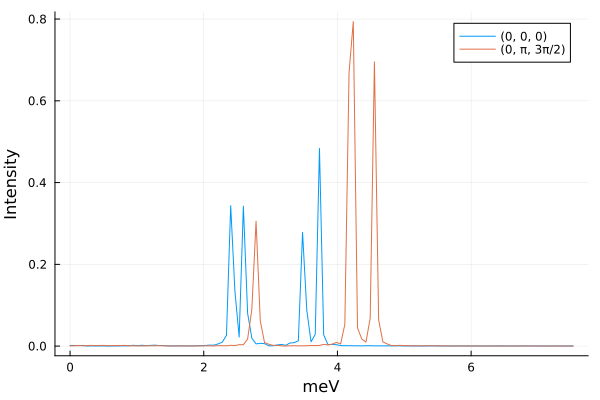

In [25]:
qs = [[0, 0, 0], [0, 0.5, 0.75]] # Wave vectors at [0,0,0] and [0, π, 3π/2]
intensities = get_intensities(sf, qs, :trace; kT)

ωs = ωvals(sf) # Get the ω values for the energy axis

Plots.plot(ωs, intensities[1,:]; label = "(0, 0, 0)", xlabel="meV", ylabel="Intensity")
Plots.plot!(ωs, intensities[2,:]; label = "(0, π, 3π/2)", xlabel="meV", ylabel="Intensity")

Also observe that we gave a temperature to the keyword argument `kT`. When a value is provided to `kT`, Sunny applies a temperature- and energy-dependent classical-to-quantum rescaling of the intensities. Users comparing results to experimental data or spin wave calculations should always provide a temperature.

### Extracting Paths

Very often we want to extract the energy intensities along lines that connect special wave vectors. Sunny provides a function `connected_path` to to make this easy, and allows to tune to the density of sample points. We provide a simple example below.

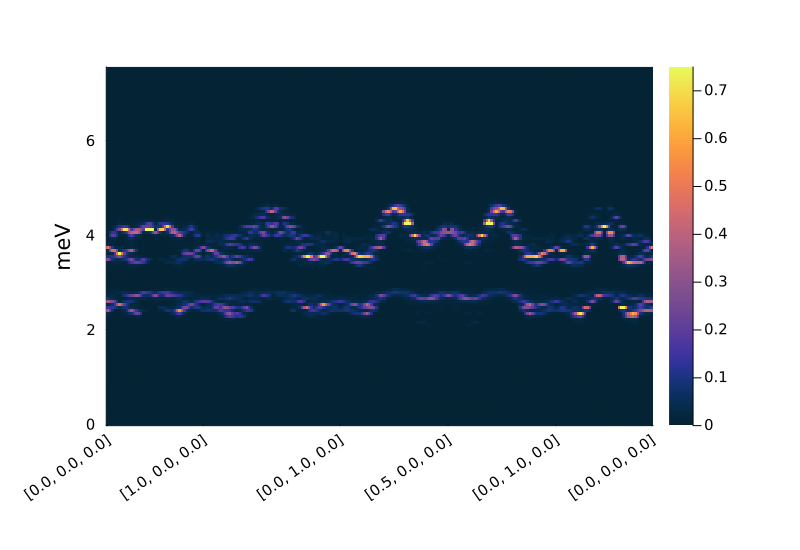

In [26]:
points = [[0.0, 0.0, 0.0],  # List of wave vectors that define a path
          [1.0, 0.0, 0.0],
          [0.0, 1.0, 0.0],
          [0.5, 0.0, 0.0],
          [0.0, 1.0, 0.0],
          [0.0, 0.0, 0.0]] 

formfactors = [FormFactor(1, "Fe2"; g_lande=3/2)]  # Ion information for each site to retrieve form factor correction parameters 

density = 40
path, markers = connected_path(points, density)

# The mode :perp applies a dipole correction factor
intensities = get_intensities(sf, path, :perp; 
    interpolation = :linear,    # Interpolate between available wave vectors
    kT,                         # Temperature for intensity correction
    formfactors,                # Form factor information 
)

Plots.heatmap(1:size(intensities, 1), ωvals(sf), intensities';
    color=:thermal, clims=(0.0, 0.75), xticks = (markers, points),
    xrotation=35, xtickfontsize=10, ytickfontsize=10,
    ylabel="meV", ylabelfontsize=14, size=(800,550), fmt=:png,
    margin=15Plots.PlotMeasures.mm
)

Note that we have specified a number of keywords here explicitly. In particular, we have applied three keywords that are useful for comparison with inelastic neutron scattering data. 

1. The mode `:perp` applies a polarization correction.
2. Setting `kT` applies a classical to quantum intensity rescaling.
3. Form factor corrections appropriate to the Fe2 ion are employed.

To get Sunny to apply the form factor correction, it is necessary to create a `FormFactor` for each unique site in the unit cell. This is achieved by calling `FormFactor(i, ionname; g_lande)`, where `i` refers to the atom in the unit cell (here there is only one choice), and `ionname` is a string specifying the ion. See this [site](https://www.ill.eu/sites/ccsl/ffacts/ffachtml.html) for a list of available ions. One may also specify a Lande g-factor. Sunny will automatically symmetry propagate the form factor information to all equivalent sites in the unit cell.

### Static Structure Factors and Single Energy Cuts

It is frequently useful to examine single energy cuts across many wave vectors. This is easily achieved by creating an array of wave vectors and calling `get_intensities`. 

In [27]:
npoints = 60 
qas = range(-2.0, 2.0, length=npoints) 
qbs = range(-2.0, 2.0, length=npoints)
qs = [[a, b, 0.0] for a in qas, b in qbs]

formfactors = [FormFactor(1, "Fe2")]

@time intensities = get_intensities(sf, qs, :perp;
    interpolation = :linear,
    kT,
    formfactors,
);

  1.919647 seconds (8.58 M allocations: 831.940 MiB, 5.61% gc time, 50.41% compilation time)


To examine the results at for a single energy, we simply choose a single element from the energy axis and plot. (Try varying `ωidx` below.)

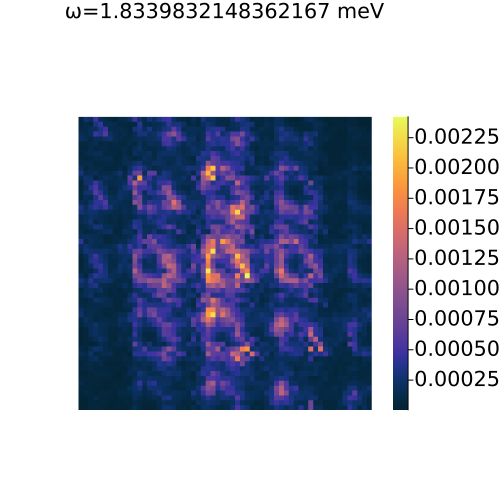

In [28]:
ωidx = 30
ω = ωvals(sf)[ωidx]
Plots.heatmap(intensities[:,:,ωidx];
    title="ω=$ω meV", color=:thermal, aspect_ratio=:equal,
    axis=([], false), margin=15Plots.PlotMeasures.mm, size=(500,500)
)

Note that Brillouin zones appear "skewed". This is a consequence of the fact that our reciprocal lattice vectors are not orthogonal. It is often useful to express our wave vectors in terms of an orthogonal basis, where each basis element is specified as a linear combination of reciprocal lattice vectors. For our crystal, with reciprocal vectors $a^*$, $b^*$ and $c^*$, we can define an orthogonal basis by taking $\hat{a}^* = 0.5(a^* + b^*)$, $\hat{b}^*=a^* - b^*$, and $\hat{c}^*=c^*$. Below, we map `qs` to wavevectors `ks` in the new coordinate system and get their intensities.

In [29]:
A = [0.5  1.0 0.0;
     0.5 -1.0 0.0;
     0.0  0.0 1.0]
ks = [A*q for q in qs]

@time intensities_ortho = get_intensities(sf, ks, :perp;
    interpolation = :linear,
    kT,
    formfactors,
);

  0.717549 seconds (5.48 M allocations: 594.442 MiB, 12.02% gc time)


We plot the results of the new calculation.

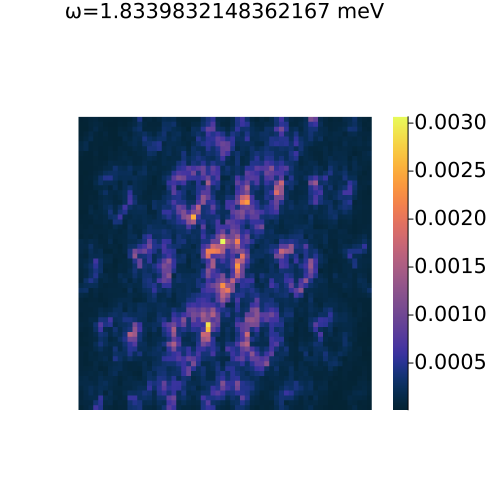

In [30]:
ωidx = 30
ω = ωvals(sf)[ωidx]
Plots.heatmap(intensities_ortho[:,:,ωidx];
    title="ω=$ω meV", color=:thermal, aspect_ratio=:equal,
    axis=([], false), margin=15Plots.PlotMeasures.mm, size=(500,500)
)

The procedure for calculating static structure factors is very similar. Sunny provides a `get_static_intensities` function, which is almost identical to `get_intensities`, but returns an array with dimensions equal to those of the wave vectors provided, i.e., there is no additional energy index. In fact, Sunny simply calls `get_intensities` behind the scenes and sums out the energy axis. We provide a simple example below, using the same wave vectors we used for the single energy cuts.

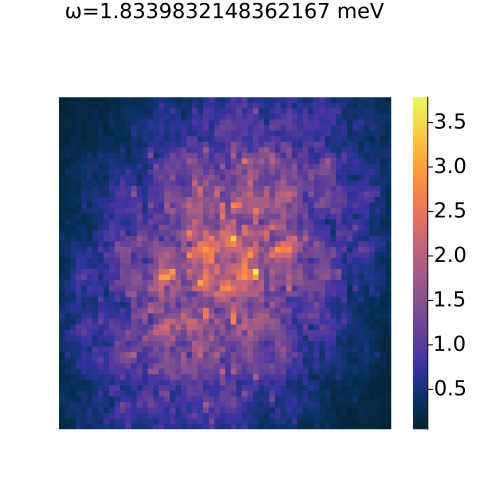

In [31]:
static_intensities = get_static_intensities(sf, ks, :perp;
    interpolation = :linear,
    kT,
    formfactors,
);

Plots.heatmap(static_intensities;
    title="ω=$ω meV", color=:thermal, aspect_ratio=:equal,
    axis=([], false), margin=10Plots.PlotMeasures.mm, size=(500,500)
)

# Getting Publication Quality Results

The workflow described above is very useful for quickly getting results. For publication quality results, you will likely want to use a larger system and take many more samples. This may require substantially more computation. 

As an example, the image below was generated using a system of $24 \times 24 \times 8$ spins. A single sample will require 3-5 minutes of computation time. (You should try it out yourself by adapting the example above.) To get thousands of samples, it will naturally be very helpful to do as many of these calculations as possible at the same time. In the an upcoming tutorial, we will outline some of Julia's basic tools for parallelism and show how they can be used with Sunny.

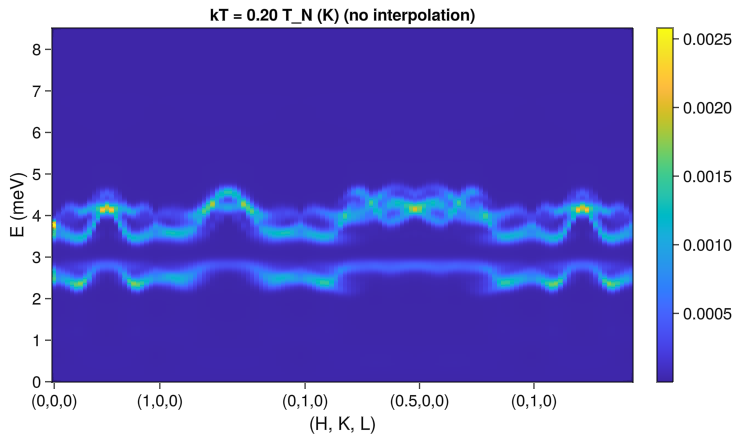



## References
\[1\] Bai et al., _Hybridized quadrupolar excitations in the spin-anisotropic frustrated magnet FeI2_, Nature Physics v. 17 (2021). (https://doi.org/10.1038/s41567-020-01110-1)

\[2\] Dahlbom et al., _Geometric integration of classical spin dynamics via a mean-field Schrödinger equation_ Physical Review B 106 (2022) (https://doi.org/10.1103/PhysRevB.106.054423).

\[3\] Dahlbom et al., _Langevin dynamics of generalized spins as SU(N) coherent states_ Physical Review B 106 (2022)(https://doi.org/10.1103/PhysRevB.106.235154)